In [12]:
# Import necessary packages
import argparse
import os

import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm

import utils
from model import Model, MyModel
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Set up the model

In [2]:
batch_size = 1
feature_dim = 128
PATH = 'results/128_0.5_200_128_50_model.pth'

# model setup
model = Model(feature_dim).cuda()
model.f[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
model = model.cuda()

model.load_state_dict(torch.load(PATH))
model.to(device)
model.eval()

Model(
  (f): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(256, eps=1e-0

### Set up LRP for this model 

In [3]:
class LRP(nn.Module):

    def __init__(self, model, eps=1.0e-9, gamma=0.1):
        super().__init__()
        self.model = model
        self.model.eval()

        self.eps = eps
        self.gamma = gamma
        self.layers = self.get_layers()

    def get_layers(self):

        # Builds list of all layers in the neural network
        # Works specifically for this CNN
        layers = nn.ModuleList()
        for module in self.model.children():
            if isinstance(module, nn.Sequential):
                for module2 in module.children():
                    if isinstance(module2, nn.Sequential):
                        for module3 in module2.children():
                            layers.append(module3)
                    else:
                        layers.append(module2)
            else:
                layers.append(module)
        return layers

    def evaluate(self, img, mode='epsilon', depth=0):
        x = img.to(device=device, dtype=torch.float)

        act = []

        with torch.no_grad():
            act.append(torch.ones_like(x))
            for layer in self.layers:
                if isinstance(layer, nn.Linear) and x.dim() > 2:
                    x = x.squeeze(dim=2)
                    x = x.squeeze(dim=2)
                x = layer(x)
                act.append(x)

        act = act[::-1]  # reverse order
        act = [a.requires_grad_(True) for a in act]

        R = act.pop(0)

        R_list = []
        R_list.append(R)
        reverse_layers = self.layers[::-1]
        for layer in reverse_layers:
            if mode is 'epsilon':
                R = self.lrp_eval_eps(layer, act.pop(0), R)
                R_list.append(R)
            elif mode is 'gamma':
                R = self.lrp_eval_gamma(layer, act.pop(0), R)
                R_list.append(R)
        return R_list[-1-depth]

    def lrp_eval_eps(self, layer, a, R):
        if isinstance(layer, nn.Linear) and a.dim() > 2:
            a = a.squeeze(dim=2)
            a = a.squeeze(dim=2)

        if isinstance(layer, nn.ReLU):
            return R

        a = a.data.requires_grad_(True)
        z = self.eps + layer.forward(a)
        s = (R / (z + 1e-9)).data  # 1e-9 to prevent divide by 0
        (z * s).sum().backward()
        c = a.grad
        R = a * c
        return R
    
    def lrp_eval_gamma(self, layer, a, R):
        if isinstance(layer, nn.Linear):
            a = a.squeeze(dim=2)
            a = a.squeeze(dim=2)

        if isinstance(layer, nn.ReLU):
            return R
        elif isinstance(layer, nn.AdaptiveAvgPool2d):
            return R
        
        a = a.data.requires_grad_(True)
        newLayer = self.gamma_rho(layer)
        z = self.eps + newLayer.forward(a)
        s = (R / (z + 1e-9)).data  # 1e-9 to prevent divide by 0
        (z * s).sum().backward()
        c = a.grad
        R = a * c
        return R
    
    def gamma_rho(self, layer):
        zero = torch.zeros_like(layer.weight)
        w_plus = torch.max(zero, layer.weight)
        rho = layer.weight + self.gamma*w_plus
        rho = nn.parameter.Parameter(rho)
        newLayer = copy.deepcopy(layer)
        newLayer.weight = rho
        return newLayer

In [4]:
lrp = LRP(model, eps=1)

### Define the datasets

In [5]:
train_data = utils.MeltpoolDataset('../train.xlsx', '../imagesPNGSmall/train/', transform=utils.test_transform)
val_data = utils.MeltpoolDataset('../val.xlsx', '../imagesPNGSmall/val/', transform=utils.test_transform)
test_data = utils.MeltpoolDataset('../test.xlsx', '../imagesPNGSmall/test/', transform=utils.test_transform)

dataloaders = dict()
dataloaders['train'] = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True, drop_last=True)
dataloaders['val'] = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True, drop_last=True)
dataloaders['test'] = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True, drop_last=True)

### Sample of LRP on an image 

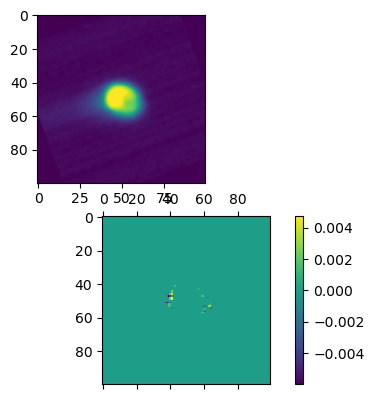

In [7]:
data_iter = iter(dataloaders['train'])
data1, _, img_name = next(data_iter)

R=lrp.evaluate(data1, mode='epsilon', depth=0)
R = R.cpu().detach().numpy().squeeze()
R[np.abs(R) < 0.2*np.max(np.abs(R))] = 0 # Only look at most important relevance

image = data1.numpy().squeeze()

data = R

fig, axs = plt.subplots(2)
axs[0].imshow(image)
heatmap = axs[1].matshow(data)
plt.colorbar(heatmap)
plt.show()

### Save the LRP results to files 

In [15]:
for phase in ['train', 'val', 'test']:
    meltpool_dataloader = dataloaders[phase]
    
    num_images = meltpool_dataloader.__len__()
    counts = 0
    for data in meltpool_dataloader:
        if (counts % 1000 == 0):
            print(str(counts) + '/' + str(num_images))    
        counts += 1
        
        data1, _, img_name = data
        R=lrp.evaluate(data1, mode='epsilon', depth=0)
        R = R.cpu().detach().numpy().squeeze()
        R[np.abs(R) < 0.2*np.max(np.abs(R))] = 0 # Only look at most important relevance
        
        img = cv2.imread(img_name[0])
        
        R = cv2.resize(R, (img.shape[1], img.shape[0]))
        R[np.abs(R) != 0] = 1 # Set all relevance to 1 for better segmentation
        R = (R-np.min(R))/(np.max(R)-np.min(R))
        R = np.uint8(255*R)
        R = cv2.applyColorMap(R, cv2.COLORMAP_JET)
        cv2.imwrite('../SimCLR_LRP_images/' + img_name[0][18:], R) # save the image

0/83232


KeyboardInterrupt: 